In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from quantum_systems import construct_psi4_system, construct_pyscf_system
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccd import OATDCCD
from coupled_cluster.integrators import GaussIntegrator

In [2]:
class LaserPulse:
    def __init__(self, t0=0, td=5, omega=0.1, E=0.03):
        self.t0 = t0
        self.td = td
        self.omega = omega
        self.E = E  # Field strength

    def __call__(self, t):
        
        T = self.td
        delta_t = t - self.t0
        return (
            -(np.sin(np.pi * delta_t / T) ** 2)
            * np.heaviside(delta_t, 1.0)
            * np.heaviside(T - delta_t, 1.0)
            * np.cos(self.omega * delta_t)
            * self.E
        )       

In [3]:
#Setup system
backend = "pyscf"
if backend == "psi4":
    He = """
    He 0.0 0.0 0.0
    symmetry c1
    """
    options = {"basis": "cc-pvdz", "scf_type": "pk", "e_convergence": 1e-8}
    system = construct_psi4_system(He, options)
    system.change_to_hf_basis(tolerance=1e-15, verbose=True)
elif backend == "pyscf":
    """
    PyScf does Hartree-Fock
    """
    system = construct_pyscf_system(molecule="he 0 0 0")

converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1


In [4]:
#Define laser pulse paramters
omega = 2.8735643
E = 100
laser_duration = 5
polarization = np.zeros(3)
polarization[2] = 1

system.set_time_evolution_operator(
    LaserField(
        LaserPulse(td=laser_duration, omega=omega, E=E),
        polarization_vector=polarization,
    )
)

In [5]:
integrator = GaussIntegrator(s=3,np=np, eps=1e-10)
cc_kwargs = dict(verbose=True)
oatdccd = OATDCCD(system, integrator=integrator, np=np, **cc_kwargs)
oatdccd.compute_ground_state()
print(
    "Ground state CCD energy: {0}".format(oatdccd.compute_ground_state_energy())
)
oatdccd.set_initial_conditions()

Iteration: 0	Residuals (t): [0.15594719219213005]
Iteration: 1	Residuals (t): [0.031910206918119445]
Iteration: 0	Residuals (l): [0.15062129737537527]
Iteration: 1	Residuals (l): [0.030640545890616776]

Iteration: 0

Residual norms: rd = 0.002234053414838409
Residual norms: ru = 0.0022344179285056893
Iteration: 0	Residuals (t): [0.0017705590127911112]
Iteration: 1	Residuals (t): [0.00041701768814427246]
Iteration: 2	Residuals (t): [1.1865829347272607e-05]
Iteration: 0	Residuals (l): [0.0017789196843479261]
Iteration: 1	Residuals (l): [0.00042022929298100517]
Iteration: 2	Residuals (l): [1.0958620703313874e-05]

Iteration: 1

Residual norms: rd = 0.00014822035617039254
Residual norms: ru = 0.00014795489055267688
Iteration: 0	Residuals (t): [1.5757622050825101e-05]
Iteration: 0	Residuals (l): [1.5665032496944927e-05]
Changing system basis...
Ground state CCD energy: (-2.887594778348555+0j)


In [6]:
dt = 1e-2
Tfinal = 1000
Nsteps = int(Tfinal / dt) + 1
timestep_stop_laser = int(laser_duration / dt)

In [7]:
#Initialize arrays to hold different "observables".
time_points = np.linspace(0, Tfinal, Nsteps)
td_energies = np.zeros(len(time_points))
td_energies_imag = np.zeros(len(time_points))
phase = np.zeros(len(time_points), dtype=np.complex128)
norm_t2 = np.zeros(len(time_points))
norm_l2 = np.zeros(len(time_points))
dip_z = np.zeros(len(time_points))

Nsteps: 100001
step stop laser: 500
dt = 0.01


In [8]:
t, l, C, C_tilde = oatdccd.amplitudes

#Set initial values
energy = oatdccd.compute_energy()
td_energies[0] = energy.real
td_energies_imag[0] = energy.imag

rho_qp = oatdccd.compute_one_body_density_matrix()
rho_qp_hermitian = 0.5 * (rho_qp.conj().T + rho_qp)

z = system.dipole_moment[2].copy()
z = C_tilde @ z @ C

dip_z[0] = (np.einsum("qp,pq->", rho_qp_hermitian, z)).real

"""
t[0][0] = tau_0
t[1] = tau-doubles

l = lambda-doubles
"""

phase[0] = t[0][0]
norm_t2[0] = np.linalg.norm(t[1])
norm_l2[0] = np.linalg.norm(l)

In [9]:
verbose = False
for i, amp in tqdm.tqdm(
    enumerate(oatdccd.solve(time_points)), total=Nsteps - 1
):
    t, l, C, C_tilde = amp
    energy = oatdccd.compute_energy()
    td_energies[i + 1] = energy.real
    td_energies_imag[i + 1] = energy.imag

    rho_qp = oatdccd.compute_one_body_density_matrix()
    rho_qp_hermitian = 0.5 * (rho_qp.conj().T + rho_qp)

    z = system.dipole_moment[2].copy()
    z = C_tilde @ z @ C

    dip_z[i + 1] = (np.einsum("qp,pq->", rho_qp_hermitian, z)).real

    phase[i + 1] = t[0][0]
    norm_t2[i + 1] = np.linalg.norm(t[1])
    norm_l2[i + 1] = np.linalg.norm(l)

    if i % 100 == 0 and verbose:
        print(f"i = {i}")
        eye = C_tilde @ C
        print(
            "C_tilde C is identity: %s" % np.allclose(eye, np.eye(eye.shape[0]))
        )
        print(
            "rho_qp_hermitian is hermitian: %s"
            % np.allclose(rho_qp_hermitian, rho_qp_hermitian.conj().T)
        )
        print("norm(t2): %g" % np.linalg.norm(t[1]))
        print("norm(l2): %g" % np.linalg.norm(l))

100%|██████████| 100000/100000 [52:12<00:00, 31.93it/s] 


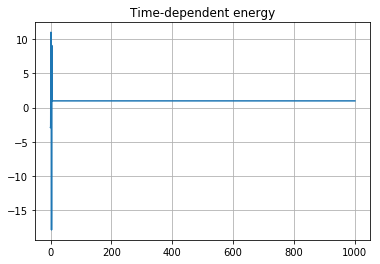

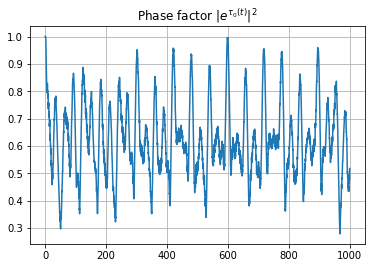

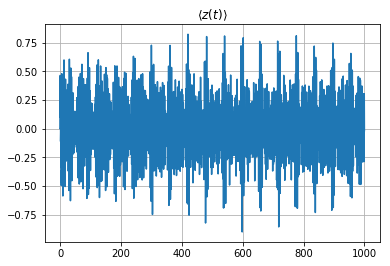

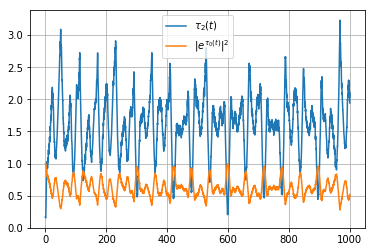

In [18]:
plt.figure()
plt.plot(time_points, td_energies)
plt.title("Time-dependent energy")
plt.grid()

np.save('he_phase',np.abs(np.exp(phase)) ** 2)
plt.figure()
plt.plot(time_points, np.abs(np.exp(phase)) ** 2)
plt.title(r"Phase factor $|e^{\tau_0(t)}|^2$")
plt.grid()

np.save('he_dip_z',dip_z)
plt.figure()
plt.plot(time_points, dip_z)
plt.title(r"$\langle z(t) \rangle$")
plt.grid()

np.save('he_norm_t2',norm_t2)
plt.figure()
plt.plot(time_points, norm_t2,label=r'$\tau_2(t)$')
plt.plot(time_points, np.abs(np.exp(phase)) ** 2,label=r'$|e^{\tau_0(t)}|^2$')
plt.legend(loc='best')
plt.grid()


plt.show()

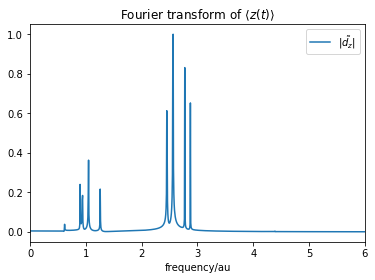

In [11]:
from scipy.fftpack import fft, ifft, fftshift, fftfreq

"""
Fourier transform of dip_z after pulse.
"""
freq = fftshift(fftfreq(len(time_points[timestep_stop_laser:]))) * (
    2 * np.pi / dt
)
a = np.abs(fftshift(fft(dip_z[timestep_stop_laser:])))
amax = a.max()
a = a / amax
plt.figure()
plt.plot(freq, a, label=r"$\vert \tilde{d_z} \vert$")
plt.title(r"Fourier transform of $\langle z(t)\rangle$")
plt.legend()
plt.xlim(0, 6)
plt.xlabel("frequency/au")
plt.show()